# Introduction


**Date**: 13th August 2020
    
**Author**: Nelson Gonzabato
    

Hello and welcome to another notebook. After a very long break from Kaggle, I have returned and decided to share what I am currently working on. 

**What's new in this version of the notebook?**

I have added text to the notebook. More importantly, I have fixed issues with `load_augmentations` that flipped images. It is defined in this notebook and will be committed to `cytounet` later. Thank you for reading and hope you like it.

As always, please let me know what could be improved. 

**Notebook Aims**


Image data is an integral part of the biomedical research indsutry especially in experiments that aim to image different stages of the cell or organisms. From imaging embryonic events to histopathological imaging, microscopy is extremely important.

Despite its importance, microscopy tasks are often time consuming and require years of expert experience to not only obtain datasets but also perform such tasks as classifying normal vs diseased samples or simply counting the number of cells in an image.

**Introducing cytounet**


To simplify image segmentation, I have written up a small deep learning based Keras/Tensorflow python package [cytounet](https://github.com/Nelson-Gon/cytounet/tree/master/cytounet). It should be noted that depsite its relative implementation simplicity, deep learning still has some flaws and limitations that we discusss at the end of this notebook.

With that short intro, let us dive right into the code. For this task, we are going to generate image labels(masks) for embryonic images from the [Broad Institute](https://data.broadinstitute.org/bbbc/BBBC009/) 

## Cloning the repository

In this notebook as stated above, we use `cytounet` an implementation of the Unet[algorithm](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). The name `cytounet` reflects the fact that this is an implementation of the Unet algorithm for biological data(`cyto`). 

This does not mean that it is limited to biological data. You can play around with different non biological datasets and judge for yourself how well it works. 



In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
! git clone https://github.com/Nelson-Gon/cytounet.git

Cloning into 'cytounet'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 966 (delta 40), reused 49 (delta 20), pack-reused 896
Receiving objects: 100% (966/966), 51.22 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (427/427), done.


For convenience, we shall `c`hange `d`irectory into our newly cloned repository.

In [3]:
%cd cytounet

/kaggle/working/cytounet


**Importing relevant modules**

Within cytounet are a few functions that will be useful for our pipeline. For convenience, we import everything from these modules.

In [4]:
from cytounet.model import *
from cytounet.data import *
from cytounet.augmentation import *

**What does our data look like?**

It is often important to understand what our data looks like. For our purposes, it is especially important to know the file format of our images. It is also a useful idea to `l`ist files in our directory to simply confirm that it in fact is not empty. 

In [5]:
!  ls examples/BBBC003_v1/

images	truth


**Image Transformations**

 First, we need to define a dictionary to define what kind of transformations will be used in our processing functions(`generate_*_data`) which generate augmented images that are then fed to our model on each epoch. This can also be useful if you need to synthesize data to escape the "curse" of small datasets which apparently do not work well for deep learning methods. 
 
 Of particular interest here is the `rescale` argument which will allow us to transform our images to a form that is recognizable by our model

In [6]:
data_generator_args =  dict(rotation_range=0.1,
                      rescale = 1./255,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    fill_mode='nearest')

In [7]:
! if [ ! -d "aug" ]; then mkdir aug;fi

**Generate training data**

Using the above arguments,we generate our train data. We also generate "fake" data which we save to `aug` to use this as our test data. You can also use this as your validation dataset and feed it to `generate_validation_data`. 

In [8]:
train_gen = generate_train_data(5, "examples/BBBC003_v1","images", "truth",aug_dict = data_generator_args,
                                 seed = 2, target_size = (512, 512), save_to_dir="aug")

In [9]:
for i, batch in enumerate(train_gen):
    if i>= 5:
        break

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


 

This section moves our images to target directories, it should be run to generate our test data.

In [10]:
! ls aug | wc -l

60


The above tells us that we have generated 60 fake images. 

In [11]:
! if [ ! -d  "aug/images" ]; then mkdir aug/images aug/masks;fi

In [12]:
! mv aug/image_* aug/images && mv aug/mask_* aug/masks && ls aug/masks | wc -l

30


In [19]:
def load_augmentations(image_path, mask_path, image_prefix="image", mask_prefix="mask"):
    image_name_arr = glob.glob(os.path.join(image_path, "{}*.png".format(image_prefix)))
    image_arr = []
    mask_arr = []
    for index, item in enumerate(image_name_arr):
        img = image.load_img(item, color_mode="grayscale", target_size = (512, 512))
        img = image.img_to_array(img)
       
        mask = image.load_img(item.replace(image_path, mask_path).replace(image_prefix, mask_prefix),
                              color_mode="grayscale", target_size = (512, 512))
        mask = image.img_to_array(mask)
       
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr, mask_arr

In [20]:
images, masks = load_augmentations("aug/images","aug/masks")

**View newly generated data**

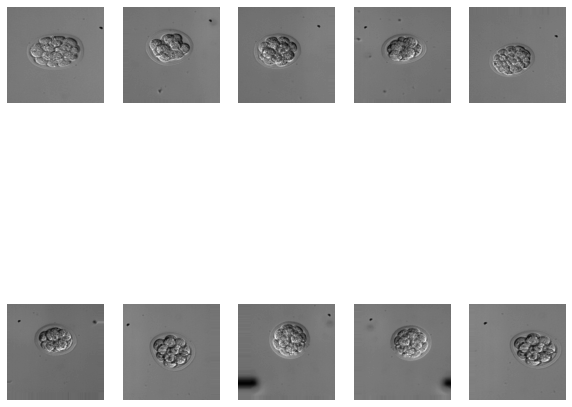

In [21]:
show_images(images, number=10)

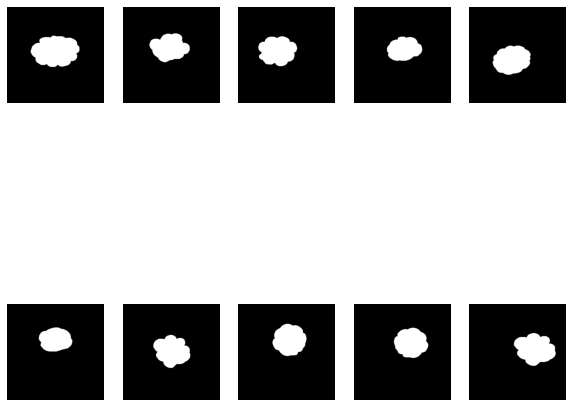

In [22]:
show_images(masks, number = 10)

# Model building and training

Next we build our model by calling `unet`. Here, we use binary cross entropy and accuracy as our loss function and metric respectively. You can alternatively use dice coeffiecient, jaccard similarity, mean IOU and so on as you may wish or as theory may allow. 

I have found `dice_coef` not to work very well so far. We also use `Adam` as our default optimizer. One could use `SGD` instead. Please try it out and let me know what your results are. 

In [23]:
model = unet(input_size = (512, 512, 1), learning_rate = 1e-4, metrics=["accuracy"],
            loss=["binary_crossentropy"])

In training our model, most of these hyperparameters are randomly chosen. This is one of the limitations of deep and machine learning in my opinion. One could perform a hyperparameter grid search but at the time of writing, this is not yet implemented in this package. 

In [24]:

history = train(model, train_gen, epochs = 5, steps_per_epoch=150, save_as="unet_embryo.hdf5")

Epoch 1/5
150/150 [==============================] - 87s 581ms/step - loss: 0.5974 - accuracy: 0.6837
Epoch 2/5
150/150 [==============================] - 87s 579ms/step - loss: 0.0362 - accuracy: 0.9931
Epoch 3/5
150/150 [==============================] - 87s 579ms/step - loss: 0.0081 - accuracy: 0.9957
Epoch 4/5
150/150 [==============================] - 86s 574ms/step - loss: 0.0057 - accuracy: 0.9962
Epoch 5/5
150/150 [==============================] - 86s 573ms/step - loss: 0.0048 - accuracy: 0.9964


# Predict on our generated data

Finally, we predict on our generated "fake" data and see how well our model does. 

In [25]:
results =  predict(model_object=unet(),test_path="aug/images", model_weights="unet_embryo.hdf5",
                  image_length=15, image_suffix="png")

15/15 [==============================] - 0s 6ms/step


# Results


From these results, it is clear that our model is overfitting on our dataset. We could overcome this by using regularizers such as `L1` and `L2` which use the absolute weights and sum square of the weights for the penalty respectively. 

Another solution is to use a simpler model and build on this to see how model complexity affects the model's output. 

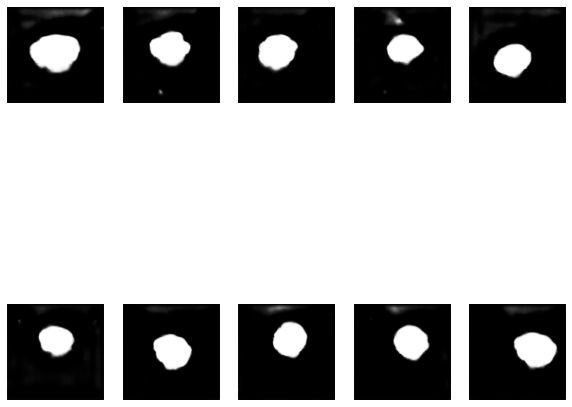

In [26]:
show_images(results, number = 10)

# Conclusion

This has been a very brief example of what the unet algorithm could do and how this could be harnessed for biological datasets. Let me know what you think could be improved, better explained or what you think is a better approach.  

For future steps, as described previously, one could try to:

* test this model on non biological data

* determine the effect of kernel regularization on predicted values

* determine if dropout is a better approach than batch normalization that this model uses.

* define a novel algorithm that does the same with similar or better results.


Thank you very much for reading. If you would like to contribute to this work, please do so at [cytounet](https://github.com/Nelson-Gon/cytounet). 